In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
# #        print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
#importing necessary libraries
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt

In [2]:
EMOTIONS = {
    1: 'neutral', 
    2: 'calm', 
    3: 'happy', 
    4: 'sad', 
    5: 'angry', 
    6: 'fear', 
    7: 'disgust', 
    0: 'surprise'  # Note: 'surprise' is mapped to 0 instead of the original 8
}

DATA_PATH='/kaggle/input/ravdess-emotional-speech-audio'
SAMPLE_RATE=48000

In [3]:
# Initialize an empty list to store data before creating the DataFrame
data_list = []

# Walk through the directory and subdirectories in DATA_PATH
for dirname, _, filenames in os.walk(DATA_PATH):
    # Iterate through each file in the directory
    for filename in filenames:
        # Construct the full file path for each audio file
        file_path = os.path.join('/kaggle/input/', dirname, filename)
        
        # Extract identifiers from the filename, splitting by '.' and '-'
        identifiers = filename.split('.')[0].split('-')
        
        # Extract emotion from the filename (3rd identifier)
        emotion = int(identifiers[2])

        # Change the emotion value for 'surprise' from 8 to 0
        if emotion == 8:  # Adjusting 'surprise' emotion mapping from 8 to 0
            emotion = 0
        
        # Determine emotion intensity: '1' indicates normal, anything else is 'strong'
        if int(identifiers[3]) == 1:
            emotion_intensity = 'normal' 
        else:
            emotion_intensity = 'strong'
        
        # Identify gender: even actor IDs indicate 'female', odd IDs indicate 'male'
        if int(identifiers[6]) % 2 == 0:
            gender = 'female'
        else:
            gender = 'male'
        
        # Add the row as a dictionary to the list
        data_list.append({"Emotion": emotion,
                          "Emotion intensity": emotion_intensity,
                          "Gender": gender,
                          "Path": file_path})

# Convert the list of dictionaries into a DataFrame
data = pd.DataFrame(data_list)


In [4]:
print(f"number of data:{len(data)}")
data.head()

number of data:2880


,Emotion,Emotion intensity,Gender,Path
0,0,normal,female,/kaggle/input/ravdess-emotional-speech-audio/A...
1,1,normal,female,/kaggle/input/ravdess-emotional-speech-audio/A...
2,7,strong,female,/kaggle/input/ravdess-emotional-speech-audio/A...
3,7,normal,female,/kaggle/input/ravdess-emotional-speech-audio/A...
4,1,normal,female,/kaggle/input/ravdess-emotional-speech-audio/A...


In [5]:
mel_spectrograms = []
signals = [] 


for i, file_path in enumerate(data.Path):
    # Load the audio file with librosa; load 3 seconds of audio starting from 0.5 seconds
    audio, sample_rate = librosa.load(file_path, duration=3, offset=0.5, sr=SAMPLE_RATE)
    
    # Create an empty signal of length 3 seconds (SAMPLE_RATE * 3) filled with zeros
    signal = np.zeros((int(SAMPLE_RATE * 3,)))
    
    signal[:len(audio)] = audio
    
    signals.append(signal)
    
    print("\rProcessed {}/{} files".format(i + 1, len(data)), end='')

signals = np.stack(signals, axis=0)

Processed 2880/2880 files

In [6]:
X = signals  # Assign the processed signals to X for simplicity

train_ind, test_ind, val_ind = [], [], [] 
X_train, X_val, X_test = [], [], [] 
Y_train, Y_val, Y_test = [], [], []  

# Loop over each emotion category (based on the EMOTIONS dictionary)
for emotion in range(len(EMOTIONS)):
    # Get indices of all samples belonging to the current emotion
    emotion_ind = list(data.loc[data.Emotion == emotion, 'Emotion'].index)
    
    # Shuffle the indices randomly
    emotion_ind = np.random.permutation(emotion_ind)

    m = len(emotion_ind)
    ind_train = emotion_ind[:int(0.8 * m)]
    ind_val = emotion_ind[int(0.8 * m):int(0.9 * m)]
    ind_test = emotion_ind[int(0.9 * m):]

    X_train.append(X[ind_train, :])
    Y_train.append(np.array([emotion] * len(ind_train), dtype=np.int32)) 
    
    X_val.append(X[ind_val, :])
    Y_val.append(np.array([emotion] * len(ind_val), dtype=np.int32))
    
    X_test.append(X[ind_test, :])
    Y_test.append(np.array([emotion] * len(ind_test), dtype=np.int32))
    
    # Store the indices used for train, validation, and test sets
    train_ind.append(ind_train)
    test_ind.append(ind_test)
    val_ind.append(ind_val)

X_train = np.concatenate(X_train, 0)
X_val = np.concatenate(X_val, 0)
X_test = np.concatenate(X_test, 0)
Y_train = np.concatenate(Y_train, 0)
Y_val = np.concatenate(Y_val, 0)
Y_test = np.concatenate(Y_test, 0)

train_ind = np.concatenate(train_ind, 0)
val_ind = np.concatenate(val_ind, 0)
test_ind = np.concatenate(test_ind, 0)

# Print the shapes of the training, validation, and test sets for both data (X) and labels (Y)
print(f'X_train: {X_train.shape}, Y_train: {Y_train.shape}')
print(f'X_val: {X_val.shape}, Y_val: {Y_val.shape}')
print(f'X_test: {X_test.shape}, Y_test: {Y_test.shape}')

# Check if all indices are unique (i.e., there are no overlaps between train, validation, and test sets)
unique, count = np.unique(np.concatenate([train_ind, test_ind, val_ind], 0), return_counts=True)
print("Number of unique indexes is {}, out of {}".format(sum(count == 1), X.shape[0]))

# Delete the original signals array to free up memory
del X


X_train: (2302, 144000), Y_train: (2302,)
X_val: (285, 144000), Y_val: (285,)
X_test: (293, 144000), Y_test: (293,)
Number of unique indexes is 2880, out of 2880


In [7]:
def addAWGN(signal, num_bits=16, augmented_num=2, snr_low=15, snr_high=30): 
    
    signal_len = len(signal)  # Length of the input signal
    noise = np.random.normal(size=(augmented_num, signal_len))

    norm_constant = 2.0 ** (num_bits - 1)
    signal_norm = signal / norm_constant 
    noise_norm = noise / norm_constant    
    
    s_power = np.sum(signal_norm ** 2) / signal_len
    
    n_power = np.sum(noise_norm ** 2, axis=1) / signal_len
    
    target_snr = np.random.randint(snr_low, snr_high)
    
    K = np.sqrt((s_power / n_power) * 10 ** (- target_snr / 10))
    
    K = np.ones((signal_len, augmented_num)) * K
    
    return signal + K.T * noise



In [8]:
aug_signals = []  # List to store the augmented signals
aug_labels = []   # List to store the corresponding labels for the augmented signals

# Loop through each sample in the training set
for i in range(X_train.shape[0]):
    signal = X_train[i, :]  # Extract the i-th signal from X_train
    
    # Generate augmented signals by adding Additive White Gaussian Noise (AWGN) to the original signal
    augmented_signals = addAWGN(signal)
    
    # Loop through each of the generated augmented signals
    for j in range(augmented_signals.shape[0]):
        # Append the emotion label of the current sample to the augmented labels
        aug_labels.append(data.loc[i, "Emotion"])
        
        # Append the j-th augmented signal to the list of augmented signals
        aug_signals.append(augmented_signals[j, :])
        
        # Create a temporary DataFrame for the current data row
        temp_df = pd.DataFrame(data.iloc[i]).T
        
        # Concatenate the current row to the original DataFrame using pd.concat
        data = pd.concat([data, temp_df], ignore_index=True)
    
    # Print the progress of the augmentation process
    print("\rProcessed {}/{} files".format(i, X_train.shape[0]), end='')

# Convert the list of augmented signals into a NumPy array for easier concatenation
aug_signals = np.stack(aug_signals, axis=0)

# Concatenate the original training signals with the augmented signals
X_train = np.concatenate([X_train, aug_signals], axis=0)

# Convert the list of augmented labels into a NumPy array
aug_labels = np.stack(aug_labels, axis=0)

# Concatenate the original training labels with the augmented labels
Y_train = np.concatenate([Y_train, aug_labels])

# Print final shapes of the augmented training data and labels
print('')
print(f'X_train: {X_train.shape}, Y_train: {Y_train.shape}')


Processed 2301/2302 files
X_train: (6906, 144000), Y_train: (6906,)


MEL spectrogram shape:  (128, 563)


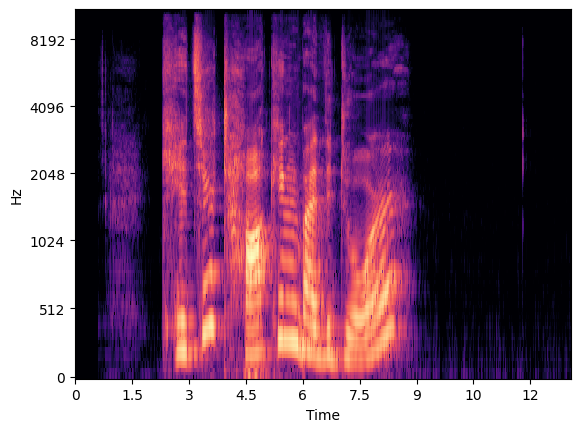

In [9]:
def getMELspectrogram(audio, sample_rate):
    mel_spec=librosa.feature.melspectrogram(y=audio,sr=sample_rate,n_fft=1024,win_length=512,window='hamming',hop_length=256,n_mels=128,fmax=sample_rate/2)
    # Convert power spectrogram to decibel scale
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

audio, sample_rate = librosa.load(data.loc[0,'Path'], duration=3, offset=0.5, sr=SAMPLE_RATE)
# Create an empty signal array of length equal to 3 seconds
signal = np.zeros((int(SAMPLE_RATE*3,)))

# Fill the signal array with the audio data
signal[:len(audio)] = audio

mel_spectrogram = getMELspectrogram(signal, SAMPLE_RATE)

librosa.display.specshow(mel_spectrogram, y_axis='mel', x_axis='time')

print('MEL spectrogram shape: ',mel_spectrogram.shape)


In [10]:
# List to store the MEL spectrograms for the training set
mel_train = []
print("Calculating MEL spectrograms for train set")

for i in range(X_train.shape[0]):
    mel_spectrogram = getMELspectrogram(X_train[i, :], sample_rate=SAMPLE_RATE)
    
    mel_train.append(mel_spectrogram)
 
    print("\rProcessed {}/{} files".format(i, X_train.shape[0]), end='')

print('') 
del X_train  

mel_val = []
print("Calculating MEL spectrograms for validation set")

for i in range(X_val.shape[0]):
    mel_spectrogram = getMELspectrogram(X_val[i, :], sample_rate=SAMPLE_RATE)

    mel_val.append(mel_spectrogram)

    print("\rProcessed {}/{} files".format(i, X_val.shape[0]), end='')

print('') 
del X_val 

mel_test = []
print("Calculating MEL spectrograms for test set")

for i in range(X_test.shape[0]):
    mel_spectrogram = getMELspectrogram(X_test[i, :], sample_rate=SAMPLE_RATE)
    
    mel_test.append(mel_spectrogram)

    print("\rProcessed {}/{} files".format(i, X_test.shape[0]), end='')

print('') 
del X_test 


Calculating MEL spectrograms for train set
Processed 6905/6906 files
Calculating MEL spectrograms for validation set
Processed 284/285 files
Calculating MEL spectrograms for test set
Processed 292/293 files


In [11]:
def splitIntoChunks(mel_spec, win_size, stride):
    t = mel_spec.shape[1]
    
    num_of_chunks = int(t / stride)

    chunks = []

    for i in range(num_of_chunks):
        chunk = mel_spec[:, i * stride:i * stride + win_size]
        if chunk.shape[1] == win_size:
            chunks.append(chunk)

    return np.stack(chunks, axis=0)


In [12]:
mel_train_chunked = []

for mel_spec in mel_train:
    chunks = splitIntoChunks(mel_spec, win_size=128, stride=64)
    mel_train_chunked.append(chunks)
print("Number of chunks is {}".format(chunks.shape[0]))
mel_val_chunked = []


for mel_spec in mel_val:
    chunks = splitIntoChunks(mel_spec, win_size=128, stride=64)
    mel_val_chunked.append(chunks)

print("Number of chunks is {}".format(chunks.shape[0]))

mel_test_chunked = []


for mel_spec in mel_test:
    chunks = splitIntoChunks(mel_spec, win_size=128, stride=64)
    mel_test_chunked.append(chunks)
print("Number of chunks is {}".format(chunks.shape[0]))


Number of chunks is 7
Number of chunks is 7
Number of chunks is 7


In [13]:

#creating a model

import torch
import torch.nn as nn

# TimeDistributed layer for applying a module to each time step in a sequence
class TimeDistributed(nn.Module):
    def __init__(self, module):
        super(TimeDistributed, self).__init__()
        self.module = module

    def forward(self, x):
        if len(x.size()) <= 2:
            return self.module(x)

        if len(x.size()) == 3:
            x_reshape = x.contiguous().view(-1, x.size(2)) 
        elif len(x.size()) == 4: 
            x_reshape = x.contiguous().view(-1, x.size(2), x.size(3))
        else: 
            x_reshape = x.contiguous().view(-1, x.size(2), x.size(3), x.size(4))
        
        # Apply the module to the reshaped tensor
        y = self.module(x_reshape)
        
        
        if len(x.size()) == 3:
            y = y.contiguous().view(x.size(0), -1, y.size(1)) 
        elif len(x.size()) == 4:
            y = y.contiguous().view(x.size(0), -1, y.size(1), y.size(2))  
        else:
            y = y.contiguous().view(x.size(0), -1, y.size(1), y.size(2), y.size(3))  
        return y



In [14]:
import torch
import torch.nn as nn

class HybridModel(nn.Module):
    def __init__(self, num_emotions):
        """
        Initialize the HybridModel with convolutional, LSTM, and attention layers.

        Parameters:
        - num_emotions: Number of emotion classes for classification.
        """
        super().__init__()

        # Convolutional Block
        self.conv2Dblock = nn.Sequential(
            # 1. Convolutional Block
            TimeDistributed(nn.Conv2d(in_channels=1,
                                   out_channels=16,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1)),
            TimeDistributed(nn.BatchNorm2d(16)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=2, stride=2)),
            TimeDistributed(nn.Dropout(p=0.3)),
            # 2. Convolutional Block
            TimeDistributed(nn.Conv2d(in_channels=16,
                                   out_channels=32,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1)),
            TimeDistributed(nn.BatchNorm2d(32)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=4, stride=4)),
            TimeDistributed(nn.Dropout(p=0.3)),
            # 3. Convolutional Block
            TimeDistributed(nn.Conv2d(in_channels=32,
                                   out_channels=64,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1)),
            TimeDistributed(nn.BatchNorm2d(64)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=4, stride=4)),
            TimeDistributed(nn.Dropout(p=0.3))
        )
        
        # LSTM Block
        hidden_size = 64
        self.lstm = nn.LSTM(input_size=1024, hidden_size=hidden_size, bidirectional=True, batch_first=True)
        self.dropout_lstm = nn.Dropout(p=0.4)
        self.attention_linear = nn.Linear(2 * hidden_size, 1)  # 2 * hidden_size for bidirectional LSTM
        
        # Linear layer for output classification
        self.out_linear = nn.Linear(2 * hidden_size, num_emotions)
    
    def forward(self, x):  
        conv_embedding = self.conv2Dblock(x)
        
        conv_embedding = torch.flatten(conv_embedding, start_dim=2)
        
        # Apply LSTM layers
        lstm_embedding, (h, c) = self.lstm(conv_embedding)
        lstm_embedding = self.dropout_lstm(lstm_embedding)
        
        # Compute attention weights
        batch_size, T, _ = lstm_embedding.shape
        attention_weights = [None] * T
        for t in range(T):
            embedding = lstm_embedding[:, t, :]
            attention_weights[t] = self.attention_linear(embedding)
        
        # Normalize attention weights
        attention_weights_norm = nn.functional.softmax(torch.stack(attention_weights, -1), dim=-1)
        
        # Apply attention to LSTM outputs
        attention = torch.bmm(attention_weights_norm, lstm_embedding)  # (Bx1xT)*(B,T,hidden_size*2) = (B,1,2*hidden_size)
        attention = torch.squeeze(attention, 1)
        
        # Compute output logits and softmax probabilities
        output_logits = self.out_linear(attention)
        output_softmax = nn.functional.softmax(output_logits, dim=1)
        
        return output_logits, output_softmax, attention_weights_norm
    
    
def loss_fnc(predictions, targets):

    loss_function = nn.CrossEntropyLoss()

    return loss_function(input=predictions, target=targets)



In [15]:
#training process
def make_train_step(model, loss_fnc, optimizer):
    def train_step(X,Y):
        model.train()
        output_logits, output_softmax, attention_weights_norm = model(X)
        predictions = torch.argmax(output_softmax, dim=1)
        accuracy = torch.sum(Y == predictions) / float(len(Y))
        loss = loss_fnc(output_logits, Y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item(), accuracy * 100
    return train_step  


In [16]:
def make_validate_fnc(model, loss_fnc):
    def validate(X, Y):
        # Disable gradient calculations for validation to save memory and computation
        with torch.no_grad():
            model.eval()
            output_logits, output_softmax, attention_weights_norm = model(X)
            predictions = torch.argmax(output_softmax, dim=1)
            accuracy = torch.sum(Y == predictions) / float(len(Y))
            loss = loss_fnc(output_logits, Y)
            
        return loss.item(), accuracy * 100, predictions
    
    return validate  # Return t


In [17]:
# Convert the list of chunked mel spectrograms for training, validation, and test sets into numpy arrays
X_train = np.stack(mel_train_chunked, axis=0)  
X_train = np.expand_dims(X_train, 2) 
print('Shape of X_train: ', X_train.shape)

X_val = np.stack(mel_val_chunked, axis=0) 
X_val = np.expand_dims(X_val, 2) 
print('Shape of X_val: ', X_val.shape)

X_test = np.stack(mel_test_chunked, axis=0)
X_test = np.expand_dims(X_test, 2)  
print('Shape of X_test: ', X_test.shape)


del mel_train_chunked
del mel_train
del mel_val_chunked
del mel_val
del mel_test_chunked
del mel_test


Shape of X_train:  (6906, 7, 1, 128, 128)
Shape of X_val:  (285, 7, 1, 128, 128)
Shape of X_test:  (293, 7, 1, 128, 128)


scaling the data

In [18]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Reshape X_train, scale it, and reshape back
b, t, c, h, w = X_train.shape
X_train = np.reshape(X_train, newshape=(b, -1))  # Flatten each sample
X_train = scaler.fit_transform(X_train)  # Fit and transform training data
X_train = np.reshape(X_train, newshape=(b, t, c, h, w))  # Reshape back to original form

b, t, c, h, w = X_test.shape
X_test = np.reshape(X_test, newshape=(b, -1)) 
X_test = scaler.transform(X_test)  
X_test = np.reshape(X_test, newshape=(b, t, c, h, w)) 

b, t, c, h, w = X_val.shape
X_val = np.reshape(X_val, newshape=(b, -1))
X_val = scaler.transform(X_val)  
X_val = np.reshape(X_val, newshape=(b, t, c, h, w))  


In [28]:
import joblib

# Save the scaler after fitting
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [19]:
EPOCHS=200
DATASET_SIZE = X_train.shape[0]
BATCH_SIZE = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print('Selected device is {}'.format(device))
model = HybridModel(num_emotions=len(EMOTIONS)).to(device) 
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()))  
OPTIMIZER = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-3, momentum=0.8)  # Define the optimizer

train_step = make_train_step(model, loss_fnc, optimizer=OPTIMIZER) 
validate = make_validate_fnc(model, loss_fnc) 
losses = []  
val_losses = [] 

for epoch in range(EPOCHS):
    # Shuffle data at the start of each epoch
    ind = np.random.permutation(DATASET_SIZE)
    X_train = X_train[ind, :, :, :, :]
    Y_train = Y_train[ind]

    epoch_acc = 0  
    epoch_loss = 0  
    iters = int(DATASET_SIZE / BATCH_SIZE)  # Number of iterations per epoch

    # Iterate over batches
    for i in range(iters):
        batch_start = i * BATCH_SIZE
        batch_end = min(batch_start + BATCH_SIZE, DATASET_SIZE)
        actual_batch_size = batch_end - batch_start

        X = X_train[batch_start:batch_end, :, :, :, :]
        Y = Y_train[batch_start:batch_end]

        # Move data to the appropriate device
        X_tensor = torch.tensor(X, device=device).float()
        Y_tensor = torch.tensor(Y, dtype=torch.long, device=device)

        #training step
        loss, acc = train_step(X_tensor, Y_tensor)
        epoch_acc += acc * actual_batch_size / DATASET_SIZE
        epoch_loss += loss * actual_batch_size / DATASET_SIZE 

        print(f"\r Epoch {epoch}: iteration {i}/{iters}", end='')  # Display training progress

    # Validation after each epoch
    X_val_tensor = torch.tensor(X_val, device=device).float()
    Y_val_tensor = torch.tensor(Y_val, dtype=torch.long, device=device)
    val_loss, val_acc, _ = validate(X_val_tensor, Y_val_tensor)

    losses.append(epoch_loss) 
    val_losses.append(val_loss)  

    # Print summary of the epoch
    print('')
    print(f"Epoch {epoch} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%")


Selected device is cuda
Number of trainable params:  582761
 Epoch 0: iteration 214/215
Epoch 0 --> loss:2.0616, acc:13.05%, val_loss:2.0503, val_acc:13.33%
 Epoch 1: iteration 214/215
Epoch 1 --> loss:2.0520, acc:14.45%, val_loss:2.0312, val_acc:17.54%
 Epoch 2: iteration 214/215
Epoch 2 --> loss:2.0434, acc:15.94%, val_loss:1.9938, val_acc:25.26%
 Epoch 3: iteration 214/215
Epoch 3 --> loss:2.0335, acc:16.52%, val_loss:1.9466, val_acc:28.07%
 Epoch 4: iteration 214/215
Epoch 4 --> loss:2.0141, acc:19.16%, val_loss:1.9064, val_acc:26.67%
 Epoch 5: iteration 214/215
Epoch 5 --> loss:1.9969, acc:20.16%, val_loss:1.8933, val_acc:28.07%
 Epoch 6: iteration 214/215
Epoch 6 --> loss:1.9833, acc:20.37%, val_loss:1.9119, val_acc:25.26%
 Epoch 7: iteration 214/215
Epoch 7 --> loss:1.9665, acc:21.03%, val_loss:1.8666, val_acc:29.47%
 Epoch 8: iteration 214/215
Epoch 8 --> loss:1.9517, acc:21.85%, val_loss:1.8641, val_acc:29.47%
 Epoch 9: iteration 214/215
Epoch 9 --> loss:1.9391, acc:21.92%, va

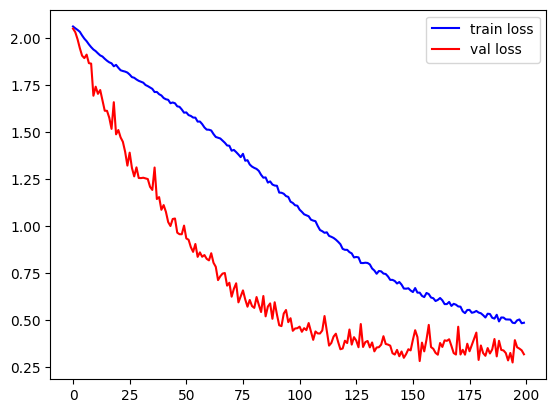

In [20]:
plt.plot(losses,'b')
plt.plot(val_losses,'r')
plt.legend(['train loss','val loss'])

In [21]:
#saving the model
SAVE_PATH = os.path.join(os.getcwd(),'models')
os.makedirs('models',exist_ok=True)
torch.save(model.state_dict(),os.path.join(SAVE_PATH,'speech_sentiment_asr.pt'))
print('Model is saved to {}'.format(os.path.join(SAVE_PATH,'speech_sentiment_asr.pt')))

Model is saved to /kaggle/working/models/speech_sentiment_asr.pt


In [22]:
#loading and testing
LOAD_PATH = os.path.join(os.getcwd(),'models')
model = HybridModel(len(EMOTIONS))
model.load_state_dict(torch.load(os.path.join(LOAD_PATH,'speech_sentiment_asr.pt')))
print('Model is loaded from {}'.format(os.path.join(LOAD_PATH,'speech_sentiment_asr.pt')))

Model is loaded from /kaggle/working/models/speech_sentiment_asr.pt


/tmp/ipykernel_36/1887058462.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(LOAD_PATH,'speech_sentiment_asr.pt')))


In [23]:
X_test_tensor = torch.tensor(X_test,device=device).float()
Y_test_tensor = torch.tensor(Y_test,dtype=torch.long,device=device)
test_loss, test_acc, predictions = validate(X_test_tensor,Y_test_tensor)
print(f'Test loss is {test_loss:.3f}')
print(f'Test accuracy is {test_acc:.2f}%')

Test loss is 0.383
Test accuracy is 87.37%


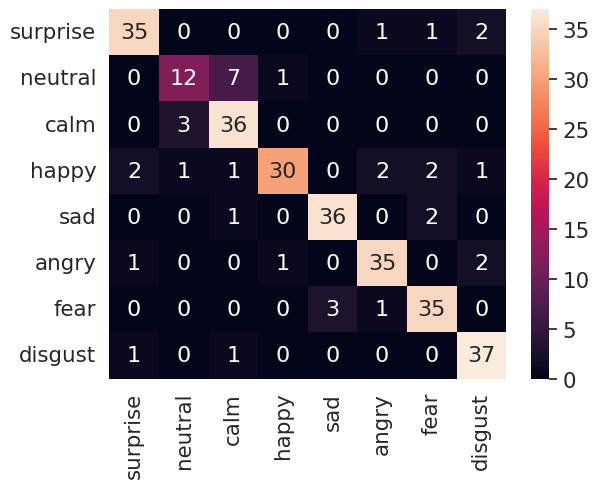

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

predictions = predictions.cpu().numpy()
cm = confusion_matrix(Y_test, predictions)
names = [EMOTIONS[ind] for ind in range(len(EMOTIONS))]
df_cm = pd.DataFrame(cm, index=names, columns=names)

sn.set(font_scale=1.4) 
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()


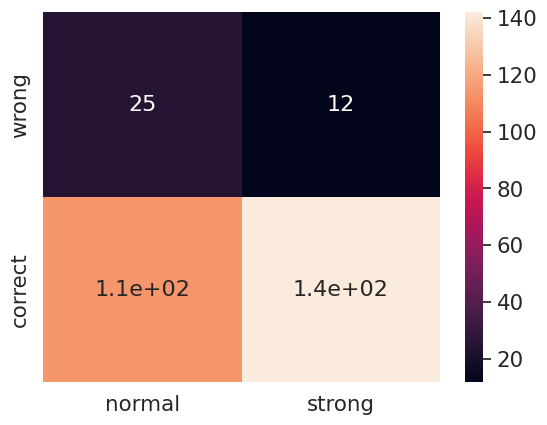

In [25]:
#Correlation between emotion intensity and correct prediction
correct_strong = 0
correct_normal = 0
wrong_strong = 0
wrong_normal = 0
for i in range(len(X_test)):
    intensity = data.loc[test_ind[i],'Emotion intensity']
    if Y_test[i] == predictions[i]: 
        if  intensity == 'normal':
            correct_normal += 1
        else:
            correct_strong += 1
    else: # wrong prediction
        if intensity == 'normal':
            wrong_normal += 1
        else:
            wrong_strong += 1
array = np.array([[wrong_normal,wrong_strong],[correct_normal,correct_strong]])
df = pd.DataFrame(array,['wrong','correct'],['normal','strong'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df, annot=True, annot_kws={"size": 16}) # font size
plt.show()

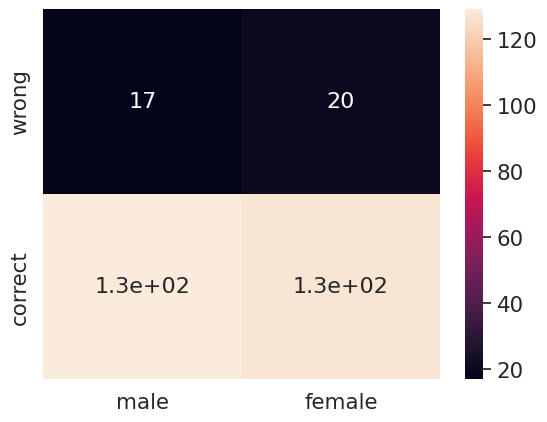

In [26]:
#correlation between gender and corectness
correct_male = 0
correct_female = 0
wrong_male = 0
wrong_female = 0
for i in range(len(X_test)):
    gender = data.loc[test_ind[i],'Gender']
    if Y_test[i] == predictions[i]: 
        if  gender == 'male':
            correct_male += 1
        else:
            correct_female += 1
    else: # wrong prediction
        if gender == 'male':
            wrong_male += 1
        else:
            wrong_female += 1
array = np.array([[wrong_male,wrong_female],[correct_male,correct_female]])
df = pd.DataFrame(array,['wrong','correct'],['male','female'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df, annot=True, annot_kws={"size": 16})
plt.show()

In [38]:
# Load the saved model
LOAD_PATH = os.path.join(os.getcwd(), 'models')
model = HybridModel(len(EMOTIONS))
model.load_state_dict(torch.load(os.path.join(LOAD_PATH, 'speech_sentiment_asr.pt'), weights_only=True)) 
print('Model is loaded from {}'.format(os.path.join(LOAD_PATH, 'speech_sentiment_asr.pt')))

Model is loaded from /kaggle/working/models/speech_sentiment_asr.pt


In [62]:
file_path = '/kaggle/input/dsdkxsd/abcde.mp3'  # Replace with the actual path to your file
predicted_emotion = predict_emotion_from_mp3(file_path)
print(f"The predicted emotion is: {predicted_emotion}")


ValueError: could not broadcast input array from shape (169344,) into shape (144000,)

In [30]:
from pydub import AudioSegment
import os

def convert_to_wav(input_file, output_file, sample_rate=48000, bitrate="768k"):
    # Load audio using pydub
    audio = AudioSegment.from_file(input_file)
    
    # Set sample rate and export as WAV
    audio = audio.set_frame_rate(sample_rate)
    
    # Export as wav file
    audio.export(output_file, format="wav", bitrate=bitrate)

# Example usage
input_file = '/kaggle/input/angryy/angry.mp3'
output_file = '/kaggle/working/angry.wav'  # Provide the filename here
convert_to_wav(input_file, output_file, sample_rate=48000, bitrate="768k")


In [44]:
import librosa
import numpy as np
import torch
from IPython.display import Audio
import os

# Load your trained model
LOAD_PATH = os.path.join(os.getcwd(), 'models')
model = HybridModel(len(EMOTIONS))
model.load_state_dict(torch.load(os.path.join(LOAD_PATH, 'speech_sentiment_asr.pt')))
print('Model is loaded from {}'.format(os.path.join(LOAD_PATH, 'speech_sentiment_asr.pt')))




SAMPLE_RATE = 48000  # Update this if your model expects a different sample rate
DURATION = 3  # Duration in seconds, same as during training
NUM_MEL_BINS = 128  # Set according to your training configuration

# # Make sure the scaler is already fitted with the training data
# scaler = StandardScaler()  # Load or define your trained StandardScaler instance here

scaler = joblib.load('scaler.pkl')


def process_audio(audio_file_path):
    # Load the audio file (WAV format)
    audio, sample_rate = librosa.load(audio_file_path, sr=SAMPLE_RATE)

    # Trim or pad the audio to ensure consistent length
    target_length = SAMPLE_RATE * DURATION
    if len(audio) > target_length:
        audio = audio[:target_length]  # Truncate if too long
    else:
        audio = np.pad(audio, (0, target_length - len(audio)), 'constant')  # Pad if too short

    # Generate mel-spectrogram
    mel_spectrogram = getMELspectrogram(audio, SAMPLE_RATE)

    # Print mel spectrogram shape
    print(f"Mel Spectrogram Shape: {mel_spectrogram.shape}")

    # Split into chunks
    chunks = splitIntoChunks(mel_spectrogram, win_size=128, stride=64)

    # Print chunk shape before scaling
    print(f"Chunks Shape Before Scaling: {chunks.shape}")

    # Check the number of chunks created
    num_chunks = chunks.shape[0]
    print(f"Number of Chunks: {num_chunks}")

    # Check if the number of chunks is equal to the sequence length expected by the model
    if num_chunks != 7:
        print(f"Warning: Expected 7 chunks, but got {num_chunks}. Adjusting the input accordingly.")
        # Adjusting chunks to fit the expected shape if necessary
        if num_chunks < 7:
            # If fewer chunks, we can pad with zeros
            padding = np.zeros((7 - num_chunks, 128, 128))
            chunks = np.concatenate((chunks, padding), axis=0)
        elif num_chunks > 7:
            # If more chunks, truncate the excess
            chunks = chunks[:7]

    # Reshape each chunk to 2D for scaling (assuming each chunk has shape (128, 128))
    chunks_reshaped = chunks.reshape(-1, 128 * 128)  # Flatten each chunk for scaling
    print(f"Chunks Shape After Flattening for Scaling: {chunks_reshaped.shape}")

    # Apply scaling
    chunks_scaled = scaler.transform(chunks_reshaped)

    # Reshape back to original chunk shape after scaling
    chunks_scaled = chunks_scaled.reshape(-1, 128, 128)
    print(f"Chunks Shape After Scaling: {chunks_scaled.shape}")

    # Add a channel dimension to match the training shape (1, 7, 128, 128)
    chunks_scaled = chunks_scaled[np.newaxis, :]  # Add a new axis for batch size
    print(f"Chunks Shape After Adding Batch Dimension: {chunks_scaled.shape}")

    # Convert to tensor for model input
    chunks_tensor = torch.tensor(chunks_scaled, device=device).float()

    # Make predictions with the model
    with torch.no_grad():
        model.eval()
        _, output_softmax, _ = model(chunks_tensor)
        predictions = torch.argmax(output_softmax, dim=1)
        predicted_emotion = EMOTIONS[predictions.item()]

    # Display the audio
    display(Audio(audio_file_path))

    # Print the predicted emotion
    print(f"Predicted Emotion: {predicted_emotion}")

    return predicted_emotion  # Return the predicted emotion

# Get the file path from the user (expecting a .wav file)
file_path = input("Enter the path to your .wav file: ")

# Process the audio file
process_audio(file_path)

/tmp/ipykernel_36/2427816377.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(LOAD_PATH, 'speech_sentiment_asr.pt')))


Model is loaded from /kaggle/working/models/speech_sentiment_asr.pt


Enter the path to your .wav file:  /kaggle/working/angry.wav


Mel Spectrogram Shape: (128, 563)
Chunks Shape Before Scaling: (7, 128, 128)
Number of Chunks: 7
Chunks Shape After Flattening for Scaling: (7, 16384)


ValueError: X has 16384 features, but StandardScaler is expecting 114688 features as input.

In [47]:
def process_audio(audio_file_path):
    # Load the audio file (WAV format)
    audio, sample_rate = librosa.load(audio_file_path, sr=SAMPLE_RATE)

    # Trim or pad the audio to ensure consistent length
    target_length = SAMPLE_RATE * DURATION
    if len(audio) > target_length:
        audio = audio[:target_length]  # Truncate if too long
    else:
        audio = np.pad(audio, (0, target_length - len(audio)), 'constant')  # Pad if too short

    # Generate mel-spectrogram
    mel_spectrogram = getMELspectrogram(audio, SAMPLE_RATE)

    # Print mel spectrogram shape
    print(f"Mel Spectrogram Shape: {mel_spectrogram.shape}")

    # Split into chunks
    chunks = splitIntoChunks(mel_spectrogram, win_size=128, stride=64)

    # Print chunk shape before scaling
    print(f"Chunks Shape Before Scaling: {chunks.shape}")

    # Check the number of chunks created
    num_chunks = chunks.shape[0]
    print(f"Number of Chunks: {num_chunks}")

    # Check if the number of chunks is equal to the sequence length expected by the model
    if num_chunks < 7:
        # If fewer chunks, we can pad with zeros to get to 7 chunks
        padding = np.zeros((7 - num_chunks, 128, 128))
        chunks = np.concatenate((chunks, padding), axis=0)
    elif num_chunks > 7:
        # If more chunks, truncate the excess
        chunks = chunks[:7]

    # Ensure the shape is (7, 1, 128, 128)
    chunks = chunks[np.newaxis, :]  # Add batch dimension
    chunks = np.expand_dims(chunks, axis=1)  # Add channel dimension

    # Reshape to match the model's expected input
    chunks_reshaped = chunks.reshape(1, 7, 1, 128, 128)

    # Print shape of reshaped chunks
    print(f"Chunks Shape After Reshaping: {chunks_reshaped.shape}")

    # Apply scaling
    chunks_scaled = scaler.transform(chunks_reshaped.reshape(1, -1))  # Flatten for scaling

    # Reshape back to original chunk shape after scaling
    chunks_scaled = chunks_scaled.reshape(1, 7, 1, 128, 128)
    print(f"Chunks Shape After Scaling: {chunks_scaled.shape}")

    # Convert to tensor for model input
    chunks_tensor = torch.tensor(chunks_scaled, device=device).float()

    # Make predictions with the model
    with torch.no_grad():
        model.eval()
        _, output_softmax, _ = model(chunks_tensor)
        predictions = torch.argmax(output_softmax, dim=1)
        predicted_emotion = EMOTIONS[predictions.item()]
    
    
    # Display the audio
    display(Audio(audio_file_path))

    # Print the predicted emotion
    print(f"Predicted Emotion: {predicted_emotion}")

    return predicted_emotion  # Return the predicted emotion


# Get the file path from the user (expecting a .wav file)
file_path = input("Enter the path to your .wav file: ")

# Process the audio file
process_audio(file_path)


Enter the path to your .wav file:  /kaggle/working/angry.wav


Mel Spectrogram Shape: (128, 563)
Chunks Shape Before Scaling: (7, 128, 128)
Number of Chunks: 7
Chunks Shape After Reshaping: (1, 7, 1, 128, 128)
Chunks Shape After Scaling: (1, 7, 1, 128, 128)


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [48]:
import librosa
import numpy as np
import torch
from IPython.display import Audio, display
import os
import joblib

# Load your trained model
LOAD_PATH = os.path.join(os.getcwd(), 'models')
model = HybridModel(len(EMOTIONS))

# Load model weights and move to the appropriate device
model.load_state_dict(torch.load(os.path.join(LOAD_PATH, 'speech_sentiment_asr.pt')))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move the model to the GPU or keep it on CPU
print('Model is loaded from {}'.format(os.path.join(LOAD_PATH, 'speech_sentiment_asr.pt')))

SAMPLE_RATE = 48000  # Update this if your model expects a different sample rate
DURATION = 3  # Duration in seconds, same as during training
NUM_MEL_BINS = 128  # Set according to your training configuration

# Load your fitted scaler
scaler = joblib.load('scaler.pkl')

def process_audio(audio_file_path):
    # Load the audio file (WAV format)
    audio, sample_rate = librosa.load(audio_file_path, sr=SAMPLE_RATE)

    # Trim or pad the audio to ensure consistent length
    target_length = SAMPLE_RATE * DURATION
    if len(audio) > target_length:
        audio = audio[:target_length]  # Truncate if too long
    else:
        audio = np.pad(audio, (0, target_length - len(audio)), 'constant')  # Pad if too short

    # Generate mel-spectrogram
    mel_spectrogram = getMELspectrogram(audio, SAMPLE_RATE)

    # Print mel spectrogram shape
    print(f"Mel Spectrogram Shape: {mel_spectrogram.shape}")

    # Split into chunks
    chunks = splitIntoChunks(mel_spectrogram, win_size=128, stride=64)

    # Print chunk shape before scaling
    print(f"Chunks Shape Before Scaling: {chunks.shape}")

    # Check the number of chunks created
    num_chunks = chunks.shape[0]
    print(f"Number of Chunks: {num_chunks}")

    # Check if the number of chunks is equal to the sequence length expected by the model
    if num_chunks < 7:
        # If fewer chunks, we can pad with zeros to get to 7 chunks
        padding = np.zeros((7 - num_chunks, 128, 128))
        chunks = np.concatenate((chunks, padding), axis=0)
    elif num_chunks > 7:
        # If more chunks, truncate the excess
        chunks = chunks[:7]

    # Ensure the shape is (7, 1, 128, 128)
    chunks = chunks[np.newaxis, :]  # Add batch dimension
    chunks = np.expand_dims(chunks, axis=1)  # Add channel dimension

    # Reshape to match the model's expected input
    chunks_reshaped = chunks.reshape(1, 7, 1, 128, 128)

    # Print shape of reshaped chunks
    print(f"Chunks Shape After Reshaping: {chunks_reshaped.shape}")

    # Apply scaling
    chunks_scaled = scaler.transform(chunks_reshaped.reshape(1, -1))  # Flatten for scaling

    # Reshape back to original chunk shape after scaling
    chunks_scaled = chunks_scaled.reshape(1, 7, 1, 128, 128)
    print(f"Chunks Shape After Scaling: {chunks_scaled.shape}")

    # Convert to tensor for model input and move to the correct device
    chunks_tensor = torch.tensor(chunks_scaled, device=device).float()

    # Make predictions with the model
    with torch.no_grad():
        model.eval()
        _, output_softmax, _ = model(chunks_tensor)
        predictions = torch.argmax(output_softmax, dim=1)
        predicted_emotion = EMOTIONS[predictions.item()]
    
    # Display the audio
    display(Audio(audio_file_path))

    # Print the predicted emotion
    print(f"Predicted Emotion: {predicted_emotion}")

    return predicted_emotion  # Return the predicted emotion


# Get the file path from the user (expecting a .wav file)
file_path = input("Enter the path to your .wav file: ")

# Process the audio file
process_audio(file_path)


/tmp/ipykernel_36/4105451506.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(LOAD_PATH, 'speech_sentiment_asr.pt')))


Model is loaded from /kaggle/working/models/speech_sentiment_asr.pt


Enter the path to your .wav file:  /kaggle/working/angry.wav


Mel Spectrogram Shape: (128, 563)
Chunks Shape Before Scaling: (7, 128, 128)
Number of Chunks: 7
Chunks Shape After Reshaping: (1, 7, 1, 128, 128)
Chunks Shape After Scaling: (1, 7, 1, 128, 128)


Predicted Emotion: sad


'sad'